# hilbert-genome-cooler

#### Overview

We use the Python `numpy-hilbert-curve` (`hilbert`) and `cooler` packages to create a multiscale `mcool` file of Hilbert curve data. 

Each scale of the `mcool` file is derived from integer-keyed categorical data (e.g., chromatin states or DHS components) at each Hilbert curve order, and put into its own `cool` file.

The set of `cool` files — each at its own "resolution" to represent Hilbert curve order — can then be loaded into a final `mcool` file.

#### Notes

1. This does not yet use the custom Hilbert curve aggregation function defined in the Observable notebook. Instead, we are generating a range of integers as placeholder data. The colormap equivalent of this data, when rendered, demonstrates that the Hilbert curve is ordered correctly.

2. This does not yet look at using HiGlass to render this `mcool` file; customization of the 2D track type will be required for presenting categorical data, similar to what was required for using HiGlass to render chromatin state or DHS component "tornado" multivec tracks. 

In [138]:
%%bash

pip install numpy-hilbert-curve
pip install cooler
pip install matplotlib
pip install h5py

In [139]:
import sys
import os
import gzip
import subprocess
import numpy as np
import hilbert
import matplotlib.pyplot as plt
import cooler
import h5py

In [140]:
data_dir = 'hilbert_genome_cooler_data'
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)

In [141]:
# The following directive activates inline plotting
%matplotlib inline

In [142]:
curve_order = { 'min': 2, 'max': 10 }
assert(curve_order['min'] > 1)
curve_orders = list(range(curve_order['min'], curve_order['max'] + 1))
curve_orders = list(reversed(curve_orders))

Create a pseudo-chromsizes file for the maximum curve order:

In [143]:
chrom_name = 'pseudo'

Specify the bin resolution, ideally as a multiple of the highest curve order:

In [144]:
bin_resolution = 2**curve_order['max'] * len(curve_orders)
bin_resolution

9216

In [145]:
chromsizes_fn = os.path.join(data_dir, 'chromsizes.txt')
with open(chromsizes_fn, 'w') as ofh:
    chrom_size = bin_resolution
    ol = '{}\t{}\n'.format(chrom_name, chrom_size)
    ofh.write(ol)

Create a vector of pseudo-categorical score data for each curve order, and write data to BG2 format (chrom1, start1, end1, chrom2, start2, end2, score).

Eventually, chromatin states (or other categorical data) will be derived from applying Observable notebook code that aggregates signal over the whole genome.

The bin size at each curve order is the `bin_resolution` divided by the order. This determines the ultimate size of a Hilbert curve cell at each coordinate pair. At the lowest orders, the bin size is the largest, and vice versa.

Coordinate pairs — BG2 pairs — need to based upon Hilbert curve ordering. We use the `hilbert` package to map locations into an index-able order, so that random access to regions of the pseudo-chromosome can be recovered via HiGlass queries later on.

In [146]:
signal_min = 0
signal_max = 4**curve_order['max'] - 1

In [147]:
def bin_size_fn(order):
    return bin_resolution // 2**order

In [148]:
for co_idx, co_val in enumerate(curve_orders):
    output_signal_fn = os.path.join(data_dir, 'bg2.signal.{}.txt.gz'.format(co_val))
    with gzip.open(output_signal_fn, 'wb') as ofh:
        signal_items = 4**co_val
        # v = np.random.randint(signal_min, high=signal_max + 1, size=signal_items)
        v = np.linspace(signal_min, signal_max + 1, num=signal_items, endpoint=False, retstep=False, dtype=np.int32, axis=0)
        locs = hilbert.decode(np.arange(signal_items), 2, co_val)
        reordered_idxs = np.lexsort((locs[:,1], locs[:,0]))
        reordered_signal = v[reordered_idxs]
        bin_size = bin_size_fn(co_val)
        for loc_idx, loc_val in enumerate(locs[reordered_idxs]):
            chrom1 = chrom_name
            start1 = loc_val[0] * bin_size
            end1 = (loc_val[0] + 1) * bin_size
            chrom2 = chrom_name
            start2 = loc_val[1] * bin_size
            end2 = (loc_val[1] + 1) * bin_size
            score = reordered_signal[loc_idx]
            ol = '{}\t{:d}\t{:d}\t{}\t{:d}\t{:d}\t{:d}\n'.format(chrom1, 
                                                                 int(start1), 
                                                                 int(end1), 
                                                                 chrom2, 
                                                                 int(start2), 
                                                                 int(end2), 
                                                                 int(score))
            ofh.write(ol.encode('utf-8'))

Next, we load the per-curve-order BG2 data into its own `cool` file. We use the `--no-symmetric-upper` option to make a square matrix: 

In [149]:
for co_idx, co_val in enumerate(curve_orders):
    input_signal_fn = os.path.join(data_dir, 'bg2.signal.{}.txt.gz'.format(co_val))
    if not os.path.exists(input_signal_fn):
        raise FileNotFoundError("Missing BG2 pair data")
    output_cool_fn =  os.path.join(data_dir, 'bg2.signal.{}.cool'.format(co_val))
    bin_size = bin_size_fn(co_val)
    cooler_load_cmd = 'cooler load -f bg2 --no-symmetric-upper {}:{:d} {} {}'.format(chromsizes_fn, bin_size, input_signal_fn, output_cool_fn)
    subprocess.run(cooler_load_cmd, shell=True, check=True, stderr=subprocess.DEVNULL)

We inspect one of the `cool` files:

In [150]:
test_cool_co = 8
test_cool_fn = os.path.join(data_dir, 'bg2.signal.{}.cool'.format(test_cool_co))
if not os.path.exists(test_cool_fn):
    raise FileNotFoundError("Missing test Cooler file data")
test_cool_fn

'hilbert_genome_cooler_data/bg2.signal.8.cool'

In [151]:
test_cool = cooler.Cooler(test_cool_fn)
test_cool.info

{'bin-size': 36,
 'bin-type': 'fixed',
 'creation-date': '2022-12-07T11:28:59.076231',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 256,
 'nchroms': 1,
 'nnz': 65536,
 'storage-mode': 'square',
 'sum': 34359214080}

Next, we can visualize the `cool` file:

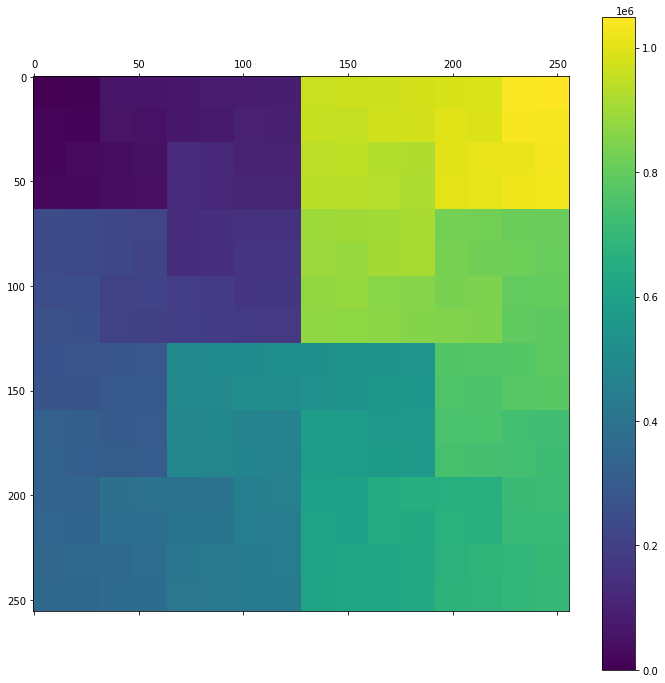

In [152]:
test_cool_arr = test_cool.matrix(balance=False)[:, :].T
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
im = ax.matshow(test_cool_arr, cmap='viridis', interpolation='nearest', vmin=signal_min, vmax=signal_max)
fig.colorbar(im)

The final step is to compile the per-curve-order `cool` files into one multiscale `mcool` file:

In [153]:
# output_mcool_fn = os.path.join(data_dir, 'bg2.signal.mcool')
# for co_idx, co_val in enumerate(curve_orders):
#     input_bg2_gz_fn =  os.path.join(data_dir, 'bg2.signal.{}.txt.gz'.format(co_val))
#     input_bg2_txt_fn =  os.path.join(data_dir, 'bg2.signal.{}.txt'.format(co_val))
#     with open(input_bg2_gz_fn, 'rb') as ifh, open(input_bg2_txt_fn, 'w', encoding='utf8') as ofh:
#         input_bg2_txt_str = gzip.decompress(ifh.read()).decode('utf-8')
#         ofh.write(input_bg2_txt_str)
#     bin_size = bin_size_fn(co_val)
#     cooler_load_cmd = 'cooler load -f bg2 --no-symmetric-upper {}:{:d} {} {}::resolutions/{:d}'.format(chromsizes_fn, bin_size, input_bg2_txt_fn, output_mcool_fn, bin_size)
#     print(cooler_load_cmd)
#     subprocess.run(cooler_load_cmd, shell=True, check=True, stderr=subprocess.DEVNULL)

Filed [issue #296](https://github.com/open2c/cooler/issues/296) as running `cooler load` overwrites `mcool` file at each resolution.

Instead, we can use `h5py` routines and the [`mcool` schema](https://cooler.readthedocs.io/en/latest/schema.html#multi-resolution) to reconstitute a container:

In [154]:
output_mcool_fn = os.path.join(data_dir, 'bg2.signal.mcool')
with h5py.File(output_mcool_fn, 'w') as output_mcool_h5:
    output_mcool_h5.attrs['format'] = 'HDF5::MCOOL'
    output_mcool_h5.attrs['format-version'] = 2
    output_mcool_h5.attrs['bin-type'] = 'fixed'
    all_resolutions = output_mcool_h5.create_group('resolutions')
    for co_idx, co_val in enumerate(curve_orders):
        bin_size = bin_size_fn(co_val)
        per_resolution = all_resolutions.create_group(str(bin_size))
        input_bg2_cool_fn =  os.path.join(data_dir, 'bg2.signal.{}.cool'.format(co_val))
        if not os.path.exists(input_bg2_cool_fn):
            raise FileNotFoundError("Cannot find per-resolution BG2 cooler file: {}".format(input_bg2_cool_fn))
        if not cooler.fileops.is_cooler(input_bg2_cool_fn):
            raise ValueError("Per-resolution BG2 file is not formatted as a cooler: {}".format(input_bg2_cool_fn))
        with h5py.File(input_bg2_cool_fn, 'r') as input_bg2_cool_h5:
            per_resolution.attrs['bin-size'] = input_bg2_cool_h5.attrs['bin-size']
            per_resolution.attrs['bin-type'] = input_bg2_cool_h5.attrs['bin-type']
            per_resolution.attrs['creation-date'] = input_bg2_cool_h5.attrs['creation-date']
            per_resolution.attrs['format'] = input_bg2_cool_h5.attrs['format']
            per_resolution.attrs['format-url'] = input_bg2_cool_h5.attrs['format-url']
            per_resolution.attrs['format-version'] = input_bg2_cool_h5.attrs['format-version']
            per_resolution.attrs['generated-by'] = input_bg2_cool_h5.attrs['generated-by']
            per_resolution.attrs['genome-assembly'] = input_bg2_cool_h5.attrs['genome-assembly']
            per_resolution.attrs['metadata'] = input_bg2_cool_h5.attrs['metadata']
            per_resolution.attrs['nbins'] = input_bg2_cool_h5.attrs['nbins']
            per_resolution.attrs['nchroms'] = input_bg2_cool_h5.attrs['nchroms']
            per_resolution.attrs['nnz'] = input_bg2_cool_h5.attrs['nnz']
            per_resolution.attrs['storage-mode'] = input_bg2_cool_h5.attrs['storage-mode']
            per_resolution.attrs['sum'] = input_bg2_cool_h5.attrs['sum']
            for input_bg2_cool_h5_group in input_bg2_cool_h5.keys():
                input_bg2_cool_h5[input_bg2_cool_h5_group].copy(input_bg2_cool_h5[input_bg2_cool_h5_group], per_resolution)

Alternatively, we can use the Python API, though the current version of `cooler` will not add some metadata required for identifying it as an `mcool`-formatted file, so we add this manually with `h5py`:

In [155]:
output_mcool_alt_fn = os.path.join(data_dir, 'bg2.signal.alt.mcool')
with h5py.File(output_mcool_alt_fn, 'w') as output_mcool_alt_h5:
    output_mcool_alt_h5.attrs['format'] = 'HDF5::MCOOL'
    output_mcool_alt_h5.attrs['format-version'] = 2
    output_mcool_alt_h5.attrs['bin-type'] = 'fixed'
for co_idx, co_val in enumerate(curve_orders):
    bin_size = bin_size_fn(co_val)
    src_uri = os.path.join(data_dir, 'bg2.signal.{}.cool'.format(co_val))
    dst_uri = '{}::resolutions/{:d}'.format(output_mcool_alt_fn, bin_size)
    if not cooler.fileops.is_cooler(src_uri):
        raise ValueError("Per-resolution BG2 file is not formatted as a cooler: {}".format(src_uri))
    cooler.fileops.cp(src_uri, dst_uri, overwrite=False)

We can use the Python API to confirm either approach generates a multiresolution file:

In [156]:
if not cooler.fileops.is_multires_file(output_mcool_fn):
    raise ValueError("Multires file is not really mcool formatted: {}".format(output_mcool_fn))
if not cooler.fileops.is_multires_file(output_mcool_alt_fn):
    raise ValueError("Multires file is not really mcool formatted: {}".format(output_mcool_alt_fn))

We can investigate their structures to confirm details, e.g. and etc.:

In [157]:
%%bash

h5ls hilbert_genome_cooler_data/bg2.signal.mcool/resolutions

1152                     Group
144                      Group
18                       Group
2304                     Group
288                      Group
36                       Group
576                      Group
72                       Group
9                        Group


In [158]:
%%bash

h5ls hilbert_genome_cooler_data/bg2.signal.alt.mcool/resolutions

1152                     Group
144                      Group
18                       Group
2304                     Group
288                      Group
36                       Group
576                      Group
72                       Group
9                        Group
